In [1]:
import numpy as np
import pandas as pd
import os
import json

import imageio
# import cv2
import geopandas as gpd
# import higra as hg

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import sys
sys.path.append('../../resuneta/src')
# from bound_dist import get_distance, get_boundary

from sklearn.metrics import matthews_corrcoef

# Helpful functions

In [2]:
def get_masked_mcc(logits, extent_mask, boundary_kernel_size=(2,2), threshold=0.5):
    boundary_mask = get_boundary(extent_mask, kernel_size=boundary_kernel_size)

    # define label mask
    label_mask = np.array((extent_mask + boundary_mask) < 1, dtype=np.float32)
    
    # mask out unlabeled pixels
    logits_with_mask = np.ma.MaskedArray(logits, mask=label_mask)
    extent_with_mask = np.ma.MaskedArray(extent_mask, mask=label_mask)
    logits_masked = logits_with_mask[logits_with_mask.mask == False].data
    extent_masked = extent_with_mask[extent_with_mask.mask == False].data
    
    # compute MCC
    img_mcc = matthews_corrcoef(extent_masked > 0, logits_masked > threshold)
    
    return img_mcc

# Consensus

In [2]:
img_dir = '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_samples/'
month_dirs = ['2020_{}'.format(str(x).zfill(2)) for x in range(7, 13)] + \
             ['2021_{}'.format(str(x).zfill(2)) for x in range(1, 8)]
label_dir = '../data/planet/india/GeneralBlockchain/extent_labels/'
results_dir = '../results/india/GeneralBlockchain/resunet-d6_all_nfilter-16_bs-8_lr-0.001_4x-downsampled-partial_finetuned/'
for month in month_dirs:
    extent_pred_dir = os.path.join(results_dir, 'planet', month, 'extent_predictions/')
    boundary_pred_dir = os.path.join(results_dir, 'planet', month, 'boundary_predictions/')

In [3]:
results_df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
results_df['sample_id'] = results_df['image_id'].str[:4]
results_df.head()

,image_path,mcc,fold,image_id,month,sample_id
0,../data/planet/india/GeneralBlockchain/monthly...,0.084213,train,0005a,2020_07,0005
1,../data/planet/india/GeneralBlockchain/monthly...,0.119843,train,0005b,2020_07,0005
2,../data/planet/india/GeneralBlockchain/monthly...,0.120791,train,0005c,2020_07,0005
3,../data/planet/india/GeneralBlockchain/monthly...,NaN,train,0009a,2020_07,0009
4,../data/planet/india/GeneralBlockchain/monthly...,0.243178,train,0009b,2020_07,0009


## 13 months

In [6]:
results_images = results_df.dropna(subset=['mcc']).drop_duplicates(subset=['image_id'])

img_dir = '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_samples/'
month_dirs = ['2020_{}'.format(str(x).zfill(2)) for x in range(7, 13)] + \
             ['2021_{}'.format(str(x).zfill(2)) for x in range(1, 8)]
image_names = results_images['image_id'].values
consensus_mccs = []

for i, image_name in enumerate(image_names):
    if i % 100 == 0:
        print(i)
    
    all_preds = np.zeros((256, 256, len(month_dirs)))
    for m, month in enumerate(month_dirs):
        predicted = np.load(os.path.join(results_dir, 'planet', month, 'extent_predictions', image_name + '.npy'))
        all_preds[:,:,m] = predicted
        
    label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels/{}.png'.format(image_name))[:256,:256]
    consensus = all_preds.mean(axis=-1)
    mcc_consensus = get_masked_mcc(consensus, label, boundary_kernel_size=(2,2), threshold=0.5)
    consensus_mccs.append(mcc_consensus)

0
100


/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


In [10]:
results_images['consensus_mcc'] = consensus_mccs
results_images[['fold', 'image_id', 'sample_id', 'consensus_mcc']].to_csv(
    '../results/india/GeneralBlockchain/resunet-d6_all_nfilter-16_bs-8_lr-0.001_4x-downsampled-partial_finetuned/results_consensus.csv', index=False)

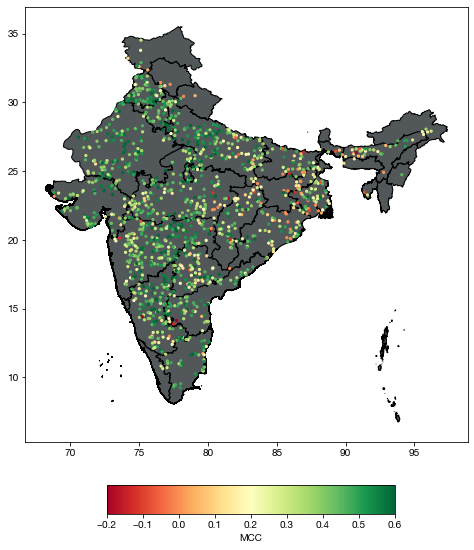

In [12]:
# consensus MCC across all months
consensus_df = pd.read_csv('../results/india/GeneralBlockchain/' + \
                           'resunet-d6_all_nfilter-16_bs-8_lr-0.001_4x-downsampled-partial_finetuned/' + \
                           'results_consensus.csv')
consensus_df['sample_id'] = consensus_df['sample_id'].astype(str).str.zfill(4)
bbox_df = pd.read_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_download.csv', dtype=str)
bbox_df = bbox_df.rename({'image_id': 'sample_id'}, axis=1)
consensus_with_latlon = consensus_df.groupby('sample_id').median().reset_index().merge(
    bbox_df, on='sample_id', how='inner')

india = gpd.read_file('../mount/data/gadm36_IND_shp/gadm36_IND_1.shp')
fig, ax = plt.subplots(1, figsize=(8,8))
india.plot(ax=ax, edgecolor='black', color='#525759')

im = plt.scatter(consensus_with_latlon['min_lon'].astype(float), consensus_with_latlon['min_lat'].astype(float), 
                 c=consensus_with_latlon['consensus_mcc'], vmin=-0.2, vmax=0.6, s=5, cmap='RdYlGn')
cax = fig.add_axes([0.27, 0, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')
cax.set_xlabel('MCC')
plt.show()

## October - February

In [7]:
results_images = results_df.dropna(subset=['mcc']).drop_duplicates(subset=['image_id'])

img_dir = '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_samples/'
month_dirs = ['2020_{}'.format(str(x).zfill(2)) for x in range(10, 13)] + \
             ['2021_{}'.format(str(x).zfill(2)) for x in range(1, 3)]
image_names = results_images['image_id'].values
consensus_mccs = []

for i, image_name in enumerate(image_names):
    if i % 100 == 0:
        print(i)
    
    all_preds = np.zeros((256, 256, len(month_dirs)))
    for m, month in enumerate(month_dirs):
        predicted = np.load(os.path.join(results_dir, 'planet', month, 'extent_predictions', image_name + '.npy'))
        all_preds[:,:,m] = predicted
        
    label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels/{}.png'.format(image_name))[:256,:256]
    consensus = all_preds.mean(axis=-1)
    mcc_consensus = get_masked_mcc(consensus, label, boundary_kernel_size=(2,2), threshold=0.5)
    consensus_mccs.append(mcc_consensus)

0
100
200


/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


In [8]:
results_images['consensus_mcc'] = consensus_mccs
results_images[['fold', 'image_id', 'sample_id', 'consensus_mcc']].to_csv(
    '../results/india/GeneralBlockchain/resunet-d6_all_nfilter-16_bs-8_lr-0.001_4x-downsampled-partial_finetuned/results_consensus_octfeb.csv', index=False)

In [10]:
print("Training set:")
print("  All months mean MCC = {:0.2f}".format(results_df[results_df['fold'] == 'train']['mcc'].mean()))
print("  Consensus mean MCC = {:0.2f}".format(results_images[results_images['fold'] == 'train']['consensus_mcc'].mean()))
print("Validation set:")
print("  All months mean MCC = {:0.2f}".format(results_df[results_df['fold'] == 'val']['mcc'].mean()))
print("  Consensus mean MCC = {:0.2f}".format(results_images[results_images['fold'] == 'val']['consensus_mcc'].mean()))

Training set:
  All months mean MCC = 0.27
  Consensus mean MCC = 0.38
Validation set:
  All months mean MCC = 0.31
  Consensus mean MCC = 0.42


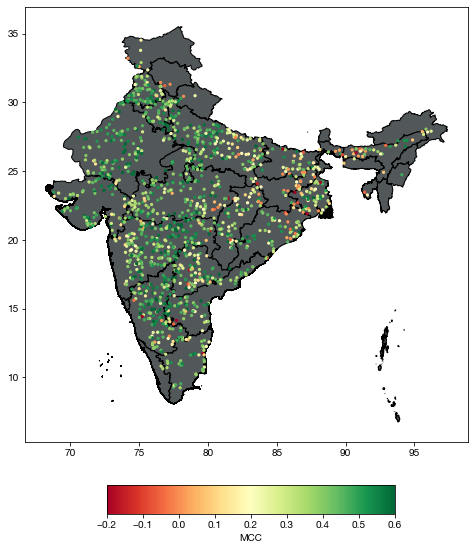

In [4]:
# consensus MCC across all months
consensus_df = pd.read_csv('../results/india/GeneralBlockchain/' + \
                           'resunet-d6_all_nfilter-16_bs-8_lr-0.001_4x-downsampled-partial_finetuned/' + \
                           'results_consensus_octfeb.csv')
consensus_df['sample_id'] = consensus_df['sample_id'].astype(str).str.zfill(4)
bbox_df = pd.read_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_download.csv', dtype=str)
bbox_df = bbox_df.rename({'image_id': 'sample_id'}, axis=1)
consensus_with_latlon = consensus_df.groupby('sample_id').median().reset_index().merge(
    bbox_df, on='sample_id', how='inner')

india = gpd.read_file('../mount/data/gadm36_IND_shp/gadm36_IND_1.shp')
fig, ax = plt.subplots(1, figsize=(8,8))
india.plot(ax=ax, edgecolor='black', color='#525759')

im = plt.scatter(consensus_with_latlon['min_lon'].astype(float), consensus_with_latlon['min_lat'].astype(float), 
                 c=consensus_with_latlon['consensus_mcc'], vmin=-0.2, vmax=0.6, s=5, cmap='RdYlGn')
cax = fig.add_axes([0.27, 0, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')
cax.set_xlabel('MCC')
plt.show()

## Relationship with field size

In [12]:
area_df = gpd.read_file('../mount/data/GeneralBlockchain/campaign_results/india_fields_with_area.shp')
area_df['sample'] = area_df['sample'].astype(str).str.zfill(4)
area_df['area_ha'] = area_df['area'] / 1e4
area_df = area_df.rename({'sample': 'sample_id'}, axis=1)

In [15]:
consensus_df = pd.read_csv('../results/india/GeneralBlockchain/' + \
                           'resunet-d6_all_nfilter-16_bs-8_lr-0.001_4x-downsampled-partial_finetuned/' + \
                           'results_consensus.csv')
consensus_df['sample_id'] = consensus_df['sample_id'].astype(str).str.zfill(4)

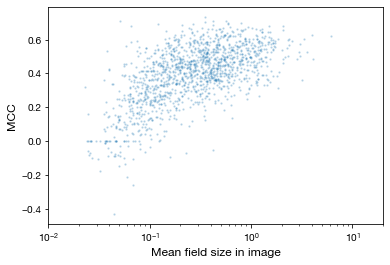

In [19]:
merged_df = area_df.merge(consensus_df, on='sample_id', how='inner')
merged_df = merged_df.groupby('sample_id').mean().reset_index()

fs = 12
plt.scatter(merged_df['area_ha'], merged_df['consensus_mcc'], alpha=0.2, s=2)
plt.xscale('log')
plt.xlim([1e-2, 20])
plt.xlabel('Mean field size in image', fontsize=fs)
plt.ylabel('MCC', fontsize=fs)
plt.show()

In [26]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(merged_df['area_ha']), merged_df['consensus_mcc'])

In [27]:
r_value**2

0.3841720371995774